## Building a simple HMM network

Refer to <a href="https://mhardik003.notion.site/NLP-751ad844946e499c9c64445a1254f648" target="_blank"> my notion page</a> for more details and explanation

***

### PROBLEM STATEMENT

`You are the security guard stationed at a secret under-ground installation. Each day, you try to guess whether it’s raining today, but your only access to the outside world occurs each morning when you see the director coming in with, or without, an umbrella.`

In this problem, *t* corresponds to each day of the week and the hidden state represent the weather outside (whether it is Rainy or Sunny) and observations record whether the security guard sees the director carrying an umbrella or not.

For example, during some particular week the guard may observe an umbrella ['yes', 'no', 'yes', 'no', 'yes'] on Monday-Friday, while the weather outside is ['Rainy', 'Sunny', 'Sunny', 'Sunny', 'Rainy']. In that case,
, , and . (It might be surprising that the guard would observe an umbrella on a sunny day, but it is possible under this type of model.)


***

In [17]:
%load_ext autoreload
%aimport helpers
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# %load_ext autoreload #reloads modules automatically before entering the execution of code typed at the IPython prompt.

# %autoreload 1
#Reload all modules imported with %aimport every time before executing the Python code typed.

We will be using python's <a href ="https://pomegranate.readthedocs.io/en/latest/index.html" target="_blank" >pomegranate library</a> for making the probability calculations easy for us.

In [19]:
!pip3 install pomegranate

Defaulting to user installation because normal site-packages is not writeable


### Importing the necessary libraries

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
import numpy as np

from helpers import show_model
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

***

We need to assume that we have some prior knowledge (possibly from a data set) about the director's behavior to estimate the emission probabilities for each hidden state. In real problems you can often estimate the emission probabilities empirically, which is what we'll do for the part of speech tagger. Our imaginary data will produce the conditional probability table below. (Note that the rows sum to 1.0)

Here we will assumen that

* Probability that the director brings the umbrella when its sunny is 0.10
* Therefore the probability that he doesnt bring the umbrella when it sunny is 0.90
* Probability that the director brings the umbrella when its rainy is 0.80
* Therefore the probability that he doesnt bring the umbrella when it rainy is 0.20

***

In [21]:
# creating the model
model = HiddenMarkovModel(name="Example Model")

# adding the probabilities to the model
sunny_emissions = DiscreteDistribution({"yes": 0.1, "no": 0.9})
sunny_state = State(sunny_emissions, name="Sunny")

rainy_emissions = DiscreteDistribution({"yes": 0.8, "no": 0.2})
rainy_state = State(rainy_emissions, name="Rainy")


# adding the states to our Sample HMM
model.add_states(sunny_state, rainy_state)

assert rainy_emissions.probability("yes") == 0.8, "The director brings his umbrella with probability 0.8 on rainy days"
print("Looks good so far!")


Looks good so far!


***
Above we added the emission probabilities,
Now we will add the transition probabilities.

* `Initial Probability `:  We will assume that we don't know anything useful about the likelihood of a sequence starting in either state. If the sequences start each week on Monday and end each week on Friday (so each week is a new sequence), then this assumption means that it's equally likely that the weather on a Monday may be Rainy or Sunny. We can assign equal probability to each starting state by setting     

    * Probability that it is rainy on monday = 0.5
    * Probability that is is sunny on monday = 0.5

<br>

* `State transition probability ` : 
    Finally, we will assume for this example that we can estimate transition probabilities from something like historical weather data for the area. In real problems you can often use the structure of the problem (like a language grammar) to impose restrictions on the transition probabilities, then re-estimate the parameters with the same training data used to estimate the emission probabilities. Under this assumption, we get the conditional probability table below. (Note that the rows sum to 1.0)
    
    * Probability for sunny => sunny day is 0.80
    * Probability for rainy => sunny day is 0.20
    * Probability for sunny => rainy day is 0.40
    * Probability for rainy => rainy day is 0.60

***

In [22]:
# create edges for each possible state transition in the model
# equal probability of a sequence starting on either a rainy or sunny day
model.add_transition(model.start, sunny_state, 0.5)
model.add_transition(model.start, rainy_state, 0.5)

# add sunny day transitions (we already know estimates of these probabilities
# from the problem statement)
model.add_transition(sunny_state, sunny_state, 0.8)  # 80% sunny->sunny
model.add_transition(sunny_state, rainy_state, 0.2)  # 20% sunny->rainy

# TODO: add rainy day transitions using the probabilities 
model.add_transition(rainy_state, sunny_state, 0.4)  # 40% rainy->sunny
model.add_transition(rainy_state, rainy_state, 0.6)  # 60% rainy->rainy

# finally, call the .bake() method to finalize the model

model.bake()

# print(model.edge_count())

assert model.edge_count() == 6, "There should be two edges from model.start, two from Rainy, and two from Sunny"
assert model.node_count() == 4, "The states should include model.start, model.end, Rainy, and Sunny"
print("Great! We've finished the model.")

Great! We've finished the model.


***
#### Visualizing the network with an image

***

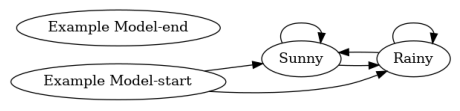

In [36]:
show_model(model, figsize=(8, 8), filename="example.png", overwrite=True, show_ends=True)

### Checking the model

In [24]:
# print(model.states)
# print(model)
# print([s.distribution for s in model.states])

column_order = ["Example Model-start", "Sunny", "Rainy", "Example Model-end"]  # Override the Pomegranate default order
column_names = [s.name for s in model.states]
order_index = [column_names.index(c) for c in column_order]
# print(order_index)

# re-order the rows/columns to match the specified column order
transitions = model.dense_transition_matrix()[:, order_index][order_index, :]
print("The state transition matrix, P(Xt|Xt-1):\n")
print(transitions)
print("\nThe transition probability from Rainy to Sunny is {:.0f}%".format(100 * transitions[2, 1]))

# both rows amd columns are as : start, to sunny day, to rainy day, end



The state transition matrix, P(Xt|Xt-1):

[[0.  0.5 0.5 0. ]
 [0.  0.8 0.2 0. ]
 [0.  0.4 0.6 0. ]
 [0.  0.  0.  0. ]]

The transition probability from Rainy to Sunny is 40%


***

#### Three most common HMM tasks
* `Likelihood evaluation `: Given a model and a set of observations , determine the likelihood of observing that sequence from the model 
    * The likelihood is often used in problems like machine translation to weight interpretations in conjunction with a statistical language model.

<br>
      
* `Hidden State Decoding `: Given a model and a set of observations , determine the most likely sequence of hidden states in the model to produce the observations
    * We can use the weather prediction model to determine the most likely sequence of Rainy/Sunny states for a known observation sequence, like [yes, no] -> [Rainy, Sunny].
    * We will use decoding in the part of speech tagger to determine the tag for each word of a sentence
    * The decoding can be further split into "smoothing" when we want to calculate past states, "filtering" when we want to calculate the current state, or "prediction" if we want to calculate future states.

<br>

* `Parameter Learning `: Given a model topography (set of states and connections) and a set of observations , learn the transition probabilities and emission probabilities of the model

***

### Using the model after it is made (implementation)

Using the <a href="https://en.wikipedia.org/wiki/Forward_algorithm" target=_blank> forward algorithm </a>


Pomegranate provides the the HMM.forward() method to calculate the full matrix showing the likelihood of aligning each observation to each state in the HMM, and the HMM.log_probability() method to calculate the cumulative likelihood over all possible hidden state paths that the specified model generated the observation sequence

***


In [25]:
# inputting a sequence of 'yes'/'no' values in the list below for testing
observations = ['yes', 'no', 'yes']

assert len(
    observations) > 0, "We need to choose a sequence of 'yes'/'no' observations to test"

# using model.forward() to calculate the forward matrix of the observed sequence,
# and then use np.exp() to convert from log-likelihood to likelihood
forward_matrix = np.exp(model.forward(observations))
print(forward_matrix)


# TODO: use model.log_probability() to calculate the all-paths likelihood of the
# observed sequence and then use np.exp() to convert log-likelihood to likelihood
probability_percentage = np.exp(model.log_probability(observations))

# Display the forward probabilities
print("         " + "".join(s.name.center(len(s.name)+6)
      for s in model.states))  # to print the top row


for i in range(len(observations) + 1):  # iterating through all the observations
    # printing the first column
    print(" <start> " if i == 0 else observations[i - 1].center(9), end="")
    # printinng the forward probability
    print("".join("{:.0f}%".format(100 * forward_matrix[i, j]).center(len(s.name) + 6)
                  for j, s in enumerate(model.states)))

print("\nThe likelihood over all possible paths " +
      "of this model producing the sequence {} is {:.2f}%\n\n"
      .format(observations, 100 * probability_percentage))


[[0.     0.     1.     0.    ]
 [0.4    0.05   0.     0.    ]
 [0.05   0.18   0.     0.    ]
 [0.0528 0.0164 0.     0.    ]]
            Rainy      Sunny      Example Model-start      Example Model-end   
 <start>      0%         0%               100%                     0%          
   yes       40%         5%                0%                      0%          
    no        5%        18%                0%                      0%          
   yes        5%         2%                0%                      0%          

The likelihood over all possible paths of this model producing the sequence ['yes', 'no', 'yes'] is 6.92%




### viterbi (using pomegranate)

In [26]:
# TODO: input a sequence of 'yes'/'no' values in the list below for testing
observations = ['yes', 'no', 'yes']

# TODO: use model.viterbi to find the sequence likelihood & the most likely path
viterbi_likelihood, viterbi_path = model.viterbi(observations)

print("The most likely weather sequence to have generated " + \
      "these observations is {} at {:.2f}%."
      .format([s[1].name for s in viterbi_path[1:]], np.exp(viterbi_likelihood)*100)
)

# print(viterbi_path)

The most likely weather sequence to have generated these observations is ['Rainy', 'Sunny', 'Rainy'] at 2.30%.


In [27]:
from itertools import product

observations = ['no', 'no', 'yes']

p = {'Sunny': {'Sunny': np.log(.8), 'Rainy': np.log(.2)}, 'Rainy': {'Sunny': np.log(.4), 'Rainy': np.log(.6)}}
e = {'Sunny': {'yes': np.log(.1), 'no': np.log(.9)}, 'Rainy':{'yes':np.log(.8), 'no':np.log(.2)}}
o = observations
k = []
vprob = np.exp(model.viterbi(o)[0])
print("The likelihood of observing {} if the weather sequence is :".format(o))
for s in product(*[['Sunny', 'Rainy']]*3):
    # print(s)
    k.append(np.exp(np.log(.5)+e[s[0]][o[0]] + p[s[0]][s[1]] + e[s[1]][o[1]] + p[s[1]][s[2]] + e[s[2]][o[2]]))
    print("\t{} is {:.2f}% {}".format(s, 100 * k[-1], " <-- Viterbi path" if k[-1] == vprob else ""))
print("\nThe total likelihood of observing {} over all possible paths is {:.2f}%".format(o, 100*sum(k)))

1
# print(product(*[['Sunny','Rainy']]*3))

The likelihood of observing ['no', 'no', 'yes'] if the weather sequence is :
	('Sunny', 'Sunny', 'Sunny') is 2.59% 
	('Sunny', 'Sunny', 'Rainy') is 5.18%  <-- Viterbi path
	('Sunny', 'Rainy', 'Sunny') is 0.07% 
	('Sunny', 'Rainy', 'Rainy') is 0.86% 
	('Rainy', 'Sunny', 'Sunny') is 0.29% 
	('Rainy', 'Sunny', 'Rainy') is 0.58% 
	('Rainy', 'Rainy', 'Sunny') is 0.05% 
	('Rainy', 'Rainy', 'Rainy') is 0.58% 

The total likelihood of observing ['no', 'no', 'yes'] over all possible paths is 10.20%


1

### viterbi (more generalized)

In [28]:
observations = ['no', 'no', 'yes']

# print(len(observations))

probability = 0.5


p = {'Sunny': {'Sunny': .8, 'Rainy': .2}, 'Rainy': {'Sunny': .4, 'Rainy': .6}}
e = {'Sunny': {'yes': .1, 'no': .9}, 'Rainy': {'yes': .8, 'no': .2}}
m = {'yes': {'Sunny': .1, 'Rainy': .8}, 'no': {'Sunny': .9, 'Rainy': .2}}

# print(p['Sunny']['Rainy'])


cartesian_product = product(*[['Sunny', 'Rainy']]*len(observations))
max_prob=0
max_prob_list=[]
for s in cartesian_product:
    # print("Working for",s)
    
    # print(s)
    probability = 0.5
    for i in range(len(observations)):
        if (i > 0):
            # print("multiplying with probability of ", s[i], " occuring after ", s[i-1], " that is : ", p[s[i-1]][s[i]])
            probability = probability*p[s[i-1]][s[i]]
        
        # print("multiplying with the probability that there is a '", observations[i],"' on ", s[i], " that is : ", m[observations[i]][s[i]])
        probability = probability*m[observations[i]][s[i]]
    
    probability*=100
    if(probability>max_prob):
        max_prob=probability
        max_prob_list=s
    print(s," => {:.2f}".format(probability))


print("Maximum probability for the observations ", observations, " is {:.2f}".format(max_prob)," for the weather sequence", max_prob_list)


('Sunny', 'Sunny', 'Sunny')  => 2.59
('Sunny', 'Sunny', 'Rainy')  => 5.18
('Sunny', 'Rainy', 'Sunny')  => 0.07
('Sunny', 'Rainy', 'Rainy')  => 0.86
('Rainy', 'Sunny', 'Sunny')  => 0.29
('Rainy', 'Sunny', 'Rainy')  => 0.58
('Rainy', 'Rainy', 'Sunny')  => 0.05
('Rainy', 'Rainy', 'Rainy')  => 0.58
Maximum probability for the observations  ['no', 'no', 'yes']  is 5.18  for the weather sequence ('Sunny', 'Sunny', 'Rainy')
